### Introduction

This project is about Herbarium challenge which consists of image classification which classifies drawings of plants into a large number of categories. Neural network is trained on  the Herbarium dataset for classification tasks. To deal with images, a standard python packages that load data into a Numpy array will be used, then we can convert this array into a torch. In this project Pillow package is used for images. For vision, torchvision package is used that had a dataloader for data and data transformers for images.

### Import packages
 Required packages are imported as follows:

In [1]:
import numpy as np 
import pandas as pd
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import imageio
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
from torch.multiprocessing import Process
from mpi4py import MPI             # MPI functions in Python
import PIL.Image  
import sys
from collections import OrderedDict
from torchvision import datasets, transforms, models

## INDEX

* [Training Configuration](#training_configuration)
* [Training network](#Training_network)
   * [Loading and Normalizing data](#loading_data)
   * [training classifier](#training_classifier)
       * [convolutional neural network](#cnn)
         * [Defining model](#define_cnn)
         * [Define loss and optimizer](#loss_function)
         * [train network](#train_network)
   * [Prediction](#predictionn)
* [Training of PyTorch network over MPI](#mpi)
* [Implementing a pipelined prediction](#pipeline)
   * [Pipelined prediction](#pipeline1)
   * [Pipelined prediction 2](#pipeline2)
   * [Pipelined prediction 3](#pipeline3)
* [other neural network and optimizer](#other_nn)
    
   

<a class="anchor" id="training_configuration"></a>
### Training Configuration

In [2]:
BATCH = 10
EPOCHS = 2
LR = 0.01
IM_SIZE = 224
#input_size = 224*224
#input_size = 28 * 28 
#hidden_size=10
#num_classes = 10
#device config
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_root = "C:/Users/kaila/3rd semester/information_retrival/scalable_analytics project/mini_herbarium/mini_herbarium/"
#dataset_root = "C:/Users/kaila/3rd semester/information_retrival/scalable_analytics project/kaggle_herbarium_1gb/kaggle_herbarium_1gb/"
train_images_dir = dataset_root + "train/"
test_images_dir = dataset_root + "test/"
train_images_dir

C:\Users\kaila\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


'C:/Users/kaila/3rd semester/information_retrival/scalable_analytics project/mini_herbarium/mini_herbarium/train/'

<a class="anchor" id="Training_network"></a>
### Training network

<a class="anchor" id="loading_data"></a>
#### Loading And Normalizing data

In [3]:
#try:
with open(train_images_dir + 'metadata.json', "r", encoding="ISO-8859-1") as file:
     train = json.load(file)  
        
print("train dict", train.keys())
#except IOError:
 #       pass

train dict dict_keys(['annotations', 'categories', 'images', 'info', 'licenses', 'institutions'])


In [4]:
all_filenames=[]
for image in train["images"]:
    all_filenames.append(image["file_name"])
all_filenames

['images/000/01/404873.jpg',
 'images/000/01/1515603.jpg',
 'images/000/00/1433074.jpg',
 'images/000/01/1104517.jpg',
 'images/000/01/1948744.jpg',
 'images/000/00/1360648.jpg',
 'images/000/01/928455.jpg',
 'images/000/01/230965.jpg',
 'images/000/00/1703060.jpg',
 'images/000/01/1486090.jpg']

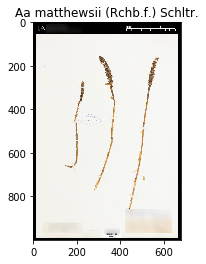

In [5]:
def plot_image(i, train):
     
    filename = train_images_dir + train["images"][i]['file_name']
    im = imageio.read(filename).get_data(0)
    plt.imshow(im)
    category = train["annotations"][i]['category_id']
    category = train["categories"][category]
    plt.title(category['name'])
#plot_image(9, train)
for x in range(10):
    plot_image(x,train)

We can take the images and annotations from the file and convert to dataframe and then merge it into one single dataframe and name it as train_df. We can use this train_df for training classifier.  We can load train_df as follows: 

In [6]:
train_img = pd.DataFrame(train['images'])
train_ann = pd.DataFrame(train['annotations']).drop(columns='image_id')
train_df = train_img.merge(train_ann, on='id')
train_df

,file_name,height,id,license,width,category_id,institution_id
0,images/000/01/404873.jpg,1000,404873,0,680,1,0
1,images/000/01/1515603.jpg,1000,1515603,0,680,1,0
2,images/000/00/1433074.jpg,1000,1433074,0,660,0,0
3,images/000/01/1104517.jpg,1000,1104517,0,680,1,0
4,images/000/01/1948744.jpg,1000,1948744,0,680,1,0
5,images/000/00/1360648.jpg,1000,1360648,0,704,0,0
6,images/000/01/928455.jpg,1000,928455,0,680,1,0
7,images/000/01/230965.jpg,1000,230965,0,680,1,0
8,images/000/00/1703060.jpg,1000,1703060,0,691,0,0
9,images/000/01/1486090.jpg,1000,1486090,0,680,1,0


In [7]:
NUM_CL = len(train_df['category_id'].value_counts())
NUM_CL

2

We can assign labels for training purpose as a category_id and assign it to Y_Train, similarly we will use file_name as X_train data as shown below:

In [8]:
X_Train, Y_Train = train_df['file_name'].values, train_df['category_id'].values

#### Transform

We will transform the loaded images to Tensors of normalized range [-1, 1] as follows:.

In [9]:
Transform = transforms.Compose(
    [transforms.RandomRotation(10),      # rotate +/- 10 degrees
     transforms.RandomHorizontalFlip(),  # reverse 50% of images
     transforms.Resize(224),             # resize shortest side to 224 pixels
     transforms.CenterCrop(224),  
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

First, we determine the transformations and put it into a list of brackets [] and pass it into the transforms.Compose() function. In the above code there are two transformations: 

ToTensor():
It Converts the type images from the dataset made up of Python Imaging Library (PIL) images into tensors to be used with torch library

Normalize(mean, std): 
Since the PIL images are RGB, which means they have three channels — red, green, and blue so we pass in 3 parameters for both the mean and standard deviation sequence

In [10]:

class GetData(Dataset):
    def __init__(self, Dir, FNames, Labels, Transform):
        self.dir = Dir
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        x = Image.open(os.path.join(self.dir, self.fnames[index]))

        if "train" in self.dir:             
            return self.transform(x), self.labels[index]
        elif "test" in self.dir:            
            return self.transform(x), self.fnames[index]
 

In [11]:
 
trainset = GetData(train_images_dir, X_Train, Y_Train, Transform)
trainloader = DataLoader(trainset, batch_size=BATCH, shuffle=True)
print(trainset)
 

We can show the training images as follows:

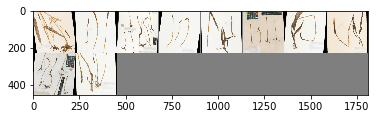

In [12]:
def img_show(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
d_img = iter(trainloader)
images, labels = d_img.next()

# show images
#img_show(torchvision.utils.make_grid(images))
img_show(torchvision.utils.make_grid(images))
 

<a class="anchor" id="training_classifiern"></a>
#### Training a classifier

Training a image classifier involves the steps as follows:
    
1) Defining a model

2) Defining a loss function

3) Training the model on the training data

In [13]:
# We can create a model as follow:

model = torchvision.models.resnet34()
model.fc = nn.Linear(512, NUM_CL, bias=True)
model = model.to(DEVICE)

# Defining a loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [14]:
examples = iter(trainloader)
samples,labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10])


In [15]:
# training loop

for epoch in range(EPOCHS):
    tr_loss = 0.0

    model = model.train()

    for i, (images, labels) in enumerate(trainloader):  
    #for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #images, labels = data
        #images = images.reshape(-1,224 * 224).to(DEVICE)
        images = images.to(DEVICE)
        labels = labels.to(DEVICE) 
        #forward pass
        outputs = model(images.float())       
        loss = criterion(outputs, labels)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss += loss.detach().item()
    
    model.eval()
    print('Epoch: %d | Loss: %.4f'%(epoch, tr_loss))

Epoch: 0 | Loss: 0.6627
Epoch: 1 | Loss: 2.4377


In the forward pass, we can get the predicted output as a model(images). To compute the loss, we will use a criterion which takes the parameter as a predicted output and labels. In the backward pass, we will call optimizer.zero_grad() to empty the value in the gadient attribute. then we call the loss.backward() which will do a back propagation. We then call a optimizer.step() which will do the update step and updates the parameters for us.

<a class="anchor" id='prediction'></a>
#### Prediction



Same data which is used for training purpose is used as a test data. We can use prediction function on images as follows:


In [16]:
with open(train_images_dir + 'metadata.json', "r", encoding="ISO-8859-1") as file:
    test = json.load(file)

In [17]:
test_df = pd.DataFrame(test['images'])
#test_df = testdf[:5]
#test_df = test_df
test_df.head()


,file_name,height,id,license,width
0,images/000/01/404873.jpg,1000,404873,0,680
1,images/000/01/1515603.jpg,1000,1515603,0,680
2,images/000/00/1433074.jpg,1000,1433074,0,660
3,images/000/01/1104517.jpg,1000,1104517,0,680
4,images/000/01/1948744.jpg,1000,1948744,0,680


In [18]:
X_Test = test_df['file_name'].values

In [19]:
class GetData_test(Dataset):
    def __init__(self, Dir, FNames, Transform):
        self.dir = Dir
        self.fnames = FNames
        self.transform = Transform
               

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        x = Image.open(os.path.join(self.dir, self.fnames[index]))
        
        if "train" in self.dir:             
            return self.transform(x), self.fnames[index]
        elif "test" in self.dir:            
            return self.transform(x), self.fnames[index]
 

In [20]:
testset = GetData_test(train_images_dir, X_Test, Transform)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [21]:
prediction = []
with torch.no_grad():
    model.eval()
    for i, (img, fname) in enumerate(testloader):  
        img = img.to(DEVICE)
        output = model(img)
        p = torch.exp(output)        
        _, topClass = p.topk(1, dim=1)
        
        for pred in topClass:
            prediction.append(pred.item())
print(prediction)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<a class="anchor" id="cnn"></a>
### Training a convolutional neural network

#### Convolutional neural network (CNN)

CNN is made up from neurons that have a learnabe weights and biases. It is mainly worked on a image data and apply the convolutional filters on image. In the CNN architecture we will first have a image, different convolutional layers, and optional activation functions followed by pooling layers. This layers are used to automatically learn some features from images and then at the end we have fully connected layers for the classification tasks. Convolutional filters works by applying filter kernel to our images, so we put a filter at the position of image then we compute the output value by multiplying and summing up all the values and then we write the value to output image. We can then slide the filter to the next position of image and repeat the same process. We have to slide the filter over whole image till we done. This is the working of CNN. 

##### Max pooling
Max pooling is used to downsample an image by applying a maximum filter to subregions. If we have an filter of size 2 by 2, then we look at 2 by 2 subregion in our original image and we write the maximum value of this region into the output image. So max pooling is used to reduce the computational cost by reducing the size of the image. This reduces the number of parameters that model has to learn and it also helps to avoid overfitting by providing abstracted form of the input.

We can define a convolutional neural network as follow:

We can create a first convolutional layer with: self.conv1 = nn.Conv2d(3, 6, 5), where 3 is input channel size, 6 is output channel size, and 5 is kernel size. For MaxPool, we have kernel size as 2 and number of srides as 2. We can then define a second convolutional layer and fully connected layers.

<a class="anchor" id="define_cnn"></a>
#### Defining a Convolutional Neural Network

Following code defines the architecture of the CNN.

In [22]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #fully connected layers
        # 16 * 53 * 53
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        print(x.shape)
        x = x.view(-1, 44944)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In this code for our forward function, we used the view function. View is used to reshape tensors. The reason of using view is that we need to flatten the output from our conv layer and give it to our fully connected layers.

<a class="anchor" id="loss_function"></a>
#### Defining a Loss function and optimizer

We can use a Classification Cross-Entropy loss and SGD with momentum as follows:



In [23]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

<a class="anchor" id="train_network"></a>
#### Train network


For training a network, we simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [24]:
# train the network

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.detach().item()
        print('Epoch: %d | Minibatch: %d | Loss: %.4f'%(epoch,i, running_loss))
         

print('Finished Training')

torch.Size([10, 16, 53, 53])
Epoch: 0 | Minibatch: 0 | Loss: 2.2283
torch.Size([10, 16, 53, 53])
Epoch: 1 | Minibatch: 0 | Loss: 2.2106
Finished Training


<a class="anchor" id="predictionn"></a>
#### Prediction

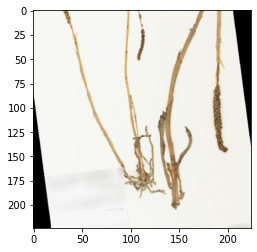

GroundTruth:  i m a g e s / 0 0 0 / 0 1 / 4 0 4 8 7 3 . j p g


In [25]:
dataiter = iter(testloader)
images, labels = dataiter.next()
 
# print images
img_show(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels))

In [26]:
outputs = net(images)

torch.Size([1, 16, 53, 53])


In [27]:
predicted = torch.max(outputs, 1)
print(predicted) 
#print('Predicted: ', ' '.join('%5s' % predicted))

torch.return_types.max(
values=tensor([0.1219], grad_fn=<MaxBackward0>),
indices=tensor([0]))


In [28]:
print(labels)

('images/000/01/404873.jpg',)


In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        
        #total += labels.size()
        #correct += (predicted == labels).sum().item()
#print('Accuracy of the network on the 10000 test images: %d %%' % (
#100 * correct / total))

torch.Size([1, 16, 53, 53])
torch.Size([1, 16, 53, 53])
torch.Size([1, 16, 53, 53])
torch.Size([1, 16, 53, 53])
torch.Size([1, 16, 53, 53])
torch.Size([1, 16, 53, 53])
torch.Size([1, 16, 53, 53])
torch.Size([1, 16, 53, 53])
torch.Size([1, 16, 53, 53])
torch.Size([1, 16, 53, 53])


In [30]:
prediction = []
with torch.no_grad():
    model.eval()
    for i, (img, fname) in enumerate(testloader):  
        img = img.to(DEVICE)
        output = model(img)
        p = torch.exp(output)        
        _, topClass = p.topk(1, dim=1)
        
        for pred in topClass:
            prediction.append(pred.item())
print(prediction)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<a class="anchor" id="mpi"></a>
#### Training of PyTorch network over MPI

In [31]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size() # number workers

filenames_to_scatter = None

if rank == 0:
     
     
    # Spliting them among <size> workers (node 0 included)
    elements_per_worker = len(all_filenames) // size
    filenames_to_scatter = []
    
    for i in range(size):
        fr = i * elements_per_worker
        to = fr + elements_per_worker
        
        if i == size-1:
            # The last worker may have more images to process if <size> does not divide len(all_filenames)
            to = len(all_filenames)
        
        filenames_to_scatter.append(all_filenames[fr:to])
        
my_filenames = comm.scatter(filenames_to_scatter, root=0)

for t in range(EPOCHS):
                #model = MNISTNetwork()
         
        for i, filename in enumerate(my_filenames):
            image = PIL.Image.open(train_images_dir + filename)        # Open the image
            image = image.resize((500, 500))                  # Resize the image to 500x500 pixels to be faster
            image = np.array(image)                           # Cast to a height,width,3 numpy array of uint8 values


        model = Net()
        
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(),lr=LR)
for k, (x, y) in enumerate(trainloader):
    opt.zero_grad()
    loss_fn(model(x), y).backward()
    opt.step()
m=comm.gather(model.state_dict(), root=0)

#if rank == 0:
    #print(m)


torch.Size([10, 16, 53, 53])


<a class="anchor" id="pipeline"></a>
#### Implementing a pipelined prediction

In [32]:

def worker_process(model, comm, rank, size):
    """Define the training process for a single epoch."""
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=LR)
    for k, (xs, ys) in enumerate(trainloader):
        opt.zero_grad()
        loss_fn(model(xs), ys).backward()
        opt.step()
    comm.send(model.state_dict(), 0)


def master_process(model, comm, rank, size):
    """Wait until all state-dicts received; then average results and perform validation."""
    #wait for all worker processes to return a state dict
     
    print("* Waiting for {0} training processes to finish...".format(size-1))
    state_dicts = []
    for p in range(size-1):
        state_dicts.append(comm.recv())
        print("(Received a trained model from process {0} of {1} workers)".format(p+1, size-1))
     
    print("* Averaging models...")
    avg_state_dict = OrderedDict()
    for key in state_dicts[0].keys():
        avg_state_dict[key] = sum([sd[key] for sd in state_dicts]) / float(size-1)
    model.load_state_dict(avg_state_dict)
    model.eval()
    with torch.no_grad():
        validation_losses = []
        validation_loader = DataLoader(trainset, batch_size=BATCH, shuffle=True)
        loss_fn = nn.CrossEntropyLoss()
        for x, y in validation_loader:
            validation_losses.append(loss_fn(model(x), y).item())
        print("* Mean validation loss of averaged model: {}".format(np.mean(validation_losses)))



"""a distributed training job."""

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
torch.manual_seed(rank)
if rank == 0:
    # build a model
    model=Net()
    # loop over some number of epochs:
    for t in range(EPOCHS):
        print("[ - - - Epoch {} - - - ]".format(t))
        [comm.send(model.state_dict(), k) for k in range(1,size)]
        master_process(model, comm, rank, size)
else:
    for t in range(EPOCHS):
        model = Net()
        model.load_state_dict(comm.recv())
        worker_process(model, comm, rank, size)

[ - - - Epoch 0 - - - ]
* Waiting for 0 training processes to finish...
* Averaging models...


IndexError: list index out of range

In above code, master-worker architecture and worker is used. Each worker trains a copy of a convolutional neural network model over an epoch through the training set, and sends the trained model's state dict back to the master server. Master server then averages the weights together and then runs a validation loop. This is considered to be one distributed epoch. 



<a class="anchor" id="pipeline1"></a>
#### Pipelined prdiction: 

Below code performs pipelined prediction is such a way that node 0 loads all images and produce pillow images. node 1 resize them and transform them into NumPy arrays. node 2 will be used for prdiction.

In [33]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size() # number workers

#if size != 3:
    #print("Need three processes")
    #exit()

#filenames = ['helene.jpg', 'denis.jpeg', 'kirk.jpeg'] #all_filenames
#filenames = ['helene.jpg', 'denis.jpeg', 'kirk.jpeg']
#print(filenames)
 
def node0():
     
    for f in all_filenames:
        # Open image
        image = PIL.Image.open(train_images_dir + f)

        # Send it to Node 1
        print('Node 0 sends', f)
        sys.stdout.flush()
        comm.send((image, f), dest=1)

    # Tell Node 1 that we are done
    comm.send((None, None), dest=1)

def node1():
    while True:
        image, filename = comm.recv(source=0)

        if image is None:
            break
        # Blur image
        image = image.resize((500, 500))                  # Resize the image to 500x500 pixels to be faster
        image = np.array(image)   
         
        # Send it to Node 2
        print('Node 1 resized', filename)
        sys.stdout.flush()
        comm.send((image, filename), dest=2)
        
    # Tell Node 2 that we are done    
    comm.send((None, None), dest=2)
    
def node2():
    image, filename = comm.recv(source=1)
    print('Node 2 saves', filename)
    prediction = []
    with torch.no_grad():
        model.eval()
        for i, (img, fname) in enumerate(testloader):
            print(i)
            img = img.to(DEVICE)
            output = model(img)
            p = torch.exp(output)        
            _, topClass = p.topk(1, dim=1)
        
            for pred in topClass:
                prediction.append(pred.item())
    print(prediction)
     
        
    
if rank == 0:
    node0()
elif rank == 1:
    node1()
else:
    node2()
            


Node 0 sends images/000/01/404873.jpg


Exception: Invalid rank, error stack:
MPI_Send(buf=0x0000015A8E8AE060, count=2040212, MPI_BYTE, dest=1, tag=0, MPI_COMM_WORLD) failed
Invalid rank has value 1 but must be nonnegative and less than 1

<a class="anchor" id="pipeline2"></a>
#### Pipelined prediction 2

Below code shows the pipelined prediction in which node 0 send the images to all other nodes and rest of the nodes performs prediction task. In this case, all nodes perform resize of image and transformation of images into NumPy arrays along with prediction.


In [34]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size() # number workers

#if size != 3:
    #print("Need three processes")
    #exit()

#filenames = ['helene.jpg', 'denis.jpeg', 'kirk.jpeg'] #all_filenames
#filenames = ['helene.jpg', 'denis.jpeg', 'kirk.jpeg']
#print(filenames)
filenames_to_scatter = None

if rank == 0:
     
     
    # Split them among <size> workers (node 0 included)
    elements_per_worker = len(all_filenames) // size
    filenames_to_scatter = []
    
    for i in range(size):
        # fr and to: define a range of filenames to give to the i-th worker
        fr = i * elements_per_worker
        to = fr + elements_per_worker
        
        if i == size-1:
            # The last worker may have more images to process if <size> does not divide len(all_filenames)
            to = len(all_filenames)
        
        filenames_to_scatter.append(all_filenames[fr:to])
        
my_filenames = comm.scatter(filenames_to_scatter, root=0)
print('I am Node', rank, 'and I got', len(my_filenames), 'images to process')
 
def node0():
     
    for i, filename in enumerate(my_filenames):
            image = PIL.Image.open(train_images_dir + filename)        # Open the image
            image = image.resize((500, 500))                  # Resize the image to 500x500 pixels to be faster
            image = np.array(image)                           # Cast to a height,width,3 numpy array of uint8 values

    print('I am Node', rank, 'and I have opened all my images')
    prediction = []
    with torch.no_grad():
        model.eval()
        for i, (img, fname) in enumerate(testloader):
            print(i)
            img = img.to(DEVICE)
            output = model(img)
            p = torch.exp(output)        
            _, topClass = p.topk(1, dim=1)
        
            for pred in topClass:
                prediction.append(pred.item())
    print(prediction)    
    

def node1():
    for i, filename in enumerate(my_filenames):
            image = PIL.Image.open(train_images_dir + filename)        # Open the image
            image = image.resize((500, 500))                  # Resize the image to 500x500 pixels to be faster
            image = np.array(image)                           # Cast to a height,width,3 numpy array of uint8 values

    print('I am Node', rank, 'and I have opened all my images')
    prediction = []
    with torch.no_grad():
        model.eval()
        for i, (img, fname) in enumerate(testloader):
            print(i)
            img = img.to(DEVICE)
            output = model(img)
            p = torch.exp(output)        
            _, topClass = p.topk(1, dim=1)
        
            for pred in topClass:
                prediction.append(pred.item())
    print(prediction) 
    
def node2():
    for i, filename in enumerate(my_filenames):
            image = PIL.Image.open(train_images_dir + filename)        # Open the image
            image = image.resize((500, 500))                  # Resize the image to 500x500 pixels to be faster
            image = np.array(image)                           # Cast to a height,width,3 numpy array of uint8 values

    print('I am Node', rank, 'and I have opened all my images')
    prediction = []
    with torch.no_grad():
        model.eval()
        for i, (img, fname) in enumerate(testloader):
            print(i)
            img = img.to(DEVICE)
            output = model(img)
            p = torch.exp(output)        
            _, topClass = p.topk(1, dim=1)
        
            for pred in topClass:
                prediction.append(pred.item())
    print(prediction) 
     
        
    
if rank == 0:
    node0()
elif rank == 1:
    node1()
else:
    node2()
            


I am Node 0 and I got 10 images to process
I am Node 0 and I have opened all my images
0
torch.Size([1, 16, 53, 53])
1
torch.Size([1, 16, 53, 53])
2
torch.Size([1, 16, 53, 53])
3
torch.Size([1, 16, 53, 53])
4
torch.Size([1, 16, 53, 53])
5
torch.Size([1, 16, 53, 53])
6
torch.Size([1, 16, 53, 53])
7
torch.Size([1, 16, 53, 53])
8
torch.Size([1, 16, 53, 53])
9
torch.Size([1, 16, 53, 53])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<a class="anchor" id="pipeline3"></a>
#### Pipelined prediction 3

In this case, node 0 scatters the images over other nodes. node 0 load all the images and produce Pillow images, Node 1 could resize them and transform them into NumPy arrays. node 2 and 3 performs prediction task.

In [35]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size() # number workers


filenames_to_scatter = None

if rank == 0:
     
     
    # Split them among <size> workers (node 0 included)
    elements_per_worker = len(all_filenames) // size
    filenames_to_scatter = []
    
    for i in range(size):
        # fr and to: define a range of filenames to give to the i-th worker
        fr = i * elements_per_worker
        to = fr + elements_per_worker
        
        if i == size-1:
            # The last worker may have more images to process if <size> does not divide len(all_filenames)
            to = len(all_filenames)
        
        filenames_to_scatter.append(all_filenames[fr:to])
        
my_filenames = comm.scatter(filenames_to_scatter, root=0)
print('I am Node', rank, 'and I got', len(my_filenames), 'images to process') 
def node0():
    for f in all_filenames:
        # Open image
        image = PIL.Image.open(train_images_dir + f)

        # Send it to Node 1
        print('Node 0 sends', f)
        sys.stdout.flush()
        comm.send((image, f), dest=1)

    # Tell Node 1 that we are done
    comm.send((None, None), dest=1)

     
    
def node1():
    while True:
        image, filename = comm.recv(source=0)

        if image is None:
            break
        # Blur image
        image = image.resize((500, 500))                  # Resize the image to 500x500 pixels to be faster
        image = np.array(image)   
         
        # Send it to Node 2
        print('Node 1 resized', filename)
        sys.stdout.flush()
        comm.send((image, filename), dest=2)
        
    # Tell Node 2 that we are done    
    comm.send((None, None), dest=2)
    
def node2():
    image, filename = comm.recv(source=0)
    print('Node 2 saves', filename)
    prediction = []
    with torch.no_grad():
        model.eval()
        for i, (img, fname) in enumerate(testloader):
            print(i)
            img = img.to(DEVICE)
            output = model(img)
            p = torch.exp(output)        
            _, topClass = p.topk(1, dim=1)
        
            for pred in topClass:
                prediction.append(pred.item())
    print(prediction)
     
def node3():
    image, filename = comm.recv(source=0)
    print('Node 3 saves', filename)
    prediction = []
    with torch.no_grad():
        model.eval()
        for i, (img, fname) in enumerate(testloader):
            print(i)
            img = img.to(DEVICE)
            output = model(img)
            p = torch.exp(output)        
            _, topClass = p.topk(1, dim=1)
        
            for pred in topClass:
                prediction.append(pred.item())
    print(prediction)        
    
if rank == 0:
    node0()
elif rank == 1:
    node1()
elif rank == 2:
    node2()
else:
    node3()
            

I am Node 0 and I got 10 images to process
Node 0 sends images/000/01/404873.jpg


Exception: Invalid rank, error stack:
MPI_Send(buf=0x0000015A91F3D060, count=2040212, MPI_BYTE, dest=1, tag=0, MPI_COMM_WORLD) failed
Invalid rank has value 1 but must be nonnegative and less than 1

<a class="anchor" id="other_nn"></a>
### other neural network and optimizer

In this below task, a pretrained model ResNet 50 is loaded and also the Adam optimizer is used. In this case, nn.ReLU() and nn.Dropout(0.2) is also used for model. ReLU is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. The nn.Dropout is a class which takes in the dropout rate as a parameter. Dropout rate is the probability a neuron being deactivated.  We can apply dropout after any non-output layer.  

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Here, Adam optimizer and learning rate of 0.003 is used.

In [38]:
# training loop
steps = 0
running_loss = 0
train_losses, test_losses = [], []
for epoch in range(EPOCHS):
    tr_loss = 0.0

    model = model.train()

    for i, (images, labels) in enumerate(trainloader):        
        #images = images.reshape(-1,224 * 224).to(DEVICE)
        steps += 1
        images = images.to(DEVICE)
        labels = labels.to(DEVICE) 
        #forward pass
        outputs = model(images.float())       
        loss = criterion(outputs, labels)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss += loss.detach().item()
        
        
        test_loss = 0
        accuracy = 0
        
        
        #model.eval()
        with torch.no_grad():
            for i, (img, labels) in enumerate(testloader):
                img = img.to(DEVICE)
                logps = model(img)
                
                #batch_loss = criterion(logps, fname)
                #test_loss += batch_loss.item()
                    
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                
                
        
                for pred in top_class:
                    prediction.append(pred.item())
                 
                
             
    
    model.eval()
    print('Epoch: %d | Loss: %.4f'%(epoch, tr_loss))

Epoch: 0 | Loss: 2.3162
Epoch: 1 | Loss: 1.8104


In this case loss is minimum compared to previous training with other optimizer and different parameters.

In [43]:
prediction = []
with torch.no_grad():
    model.eval()
    for i, (img, fname) in enumerate(testloader):  
        img = img.to(DEVICE)
        output = model(img)
        p = torch.exp(output)        
        _, topClass = p.topk(1, dim=1)
        
        for pred in topClass:
            prediction.append(pred.item())
print(prediction)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [40]:
trainset = GetData(train_images_dir, X_Train, Y_Train, Transform)
train_loader = torch.utils.data.DataLoader(trainset,
                                             batch_size=100,
                                                shuffle=True,
                                                num_workers=0,
                                                )

In [41]:
# training loop

for epoch in range(EPOCHS):
    tr_loss = 0.0

    model = model.train()

    for i, (images, labels) in enumerate(train_loader):  
    #for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #images, labels = data
        #images = images.reshape(-1,224 * 224).to(DEVICE)
        images = images.to(DEVICE)
        labels = labels.to(DEVICE) 
        #forward pass
        outputs = model(images.float())       
        loss = criterion(outputs, labels)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss += loss.detach().item()
    
    model.eval()
    print('Epoch: %d | Loss: %.4f'%(epoch, tr_loss))

Epoch: 0 | Loss: 1.0335
Epoch: 1 | Loss: 0.8820
